In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import inference, get_loglik, get_peak_pred, plot_params, simulate_lc, infer_lgfs
from matplotlib.offsetbox import AnchoredText

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-fixrho-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
# Y = Y[:, 2:]
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([100000, 5])
normalized X mean: -1.1743464469848672
X std: 1.046597228312195


In [3]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [4]:
size = 4096 * 4

In [5]:
pis, locs, scales = inference(model, size, min(4096, size), coeffs, device, full_cov=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
pred_global, pred_global_loglik, pred_close, pred_close_loglik = get_peak_pred(pis, locs, scales, Y, n_step=1000)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.06762092147050028
mse of log10q close:  0.02971792171591168
constraint 0.99444580078125
correct 0.8993432762536059
mse of log10s global:  0.013037908107922207
mse of log10s close:  0.001487331331740747
constraint 0.9891357421875
correct 0.8725780575095644
mse of u0:  0.01006168278251859
mse of u0:  0.0034037527313319224
constraint 0.99114990234375
correct 0.9019644066752879
mse of alpha global:  6255.688517636939
mse of alpha close:  240.7645058671983
constraint 0.9871826171875
correct 0.7598615061209348
mse of log10fs global:  0.0033046815375953314
mse of log10fs close:  0.0022278369326618405


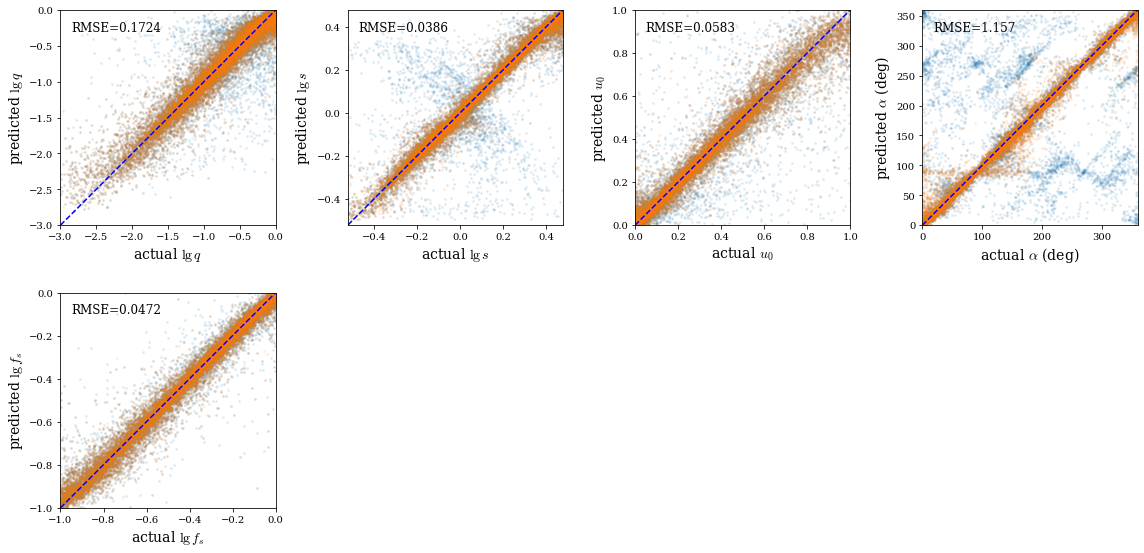

In [7]:
rmse = plot_params(size, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik, title=None)

In [9]:
n_points_list = [400, 300, 200, 100]
mse_global = np.zeros((len(n_points_list), output_dim))
mse_close = np.zeros((len(n_points_list), output_dim))
loglik_global = np.zeros((len(n_points_list), output_dim))
loglik_close = np.zeros((len(n_points_list), output_dim))
for i in tqdm(range(len(n_points_list))):
    n_points = n_points_list[i]
    subsample_ind = torch.argsort(torch.rand_like(X[:, :, 0]), dim=1)[:, :n_points]
    X_sub = X[torch.arange(X.shape[0]).unsqueeze(-1), subsample_ind]
    order = np.argsort(X_sub[:, :, 0].numpy(), axis=1)
    X_sub = X_sub[torch.arange(X_sub.shape[0]).unsqueeze(-1), order]

    # CDE interpolation with log_sig
    depth = 3; window_length = max(n_points//100, 1)
    logsig = torchcde.logsig_windows(X_sub, depth, window_length=window_length)
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

    pis, locs, scales = inference(model, size, 4096, coeffs, device)
    pred_sub = get_peak_pred(pis, locs, scales, Y)

    mse_global[i] = torch.mean((pred_sub[0] - Y[:size])**2, dim=0).numpy()
    mse_close[i] = torch.mean((pred_sub[2] - Y[:size])**2, dim=0).numpy()
    loglik_global[i] = torch.mean(pred_sub[1], dim=0).numpy()
    loglik_close[i] = torch.mean(pred_sub[3], dim=0).numpy()

np.save('./mse_sub.npy', mse_close)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.07742165326243258
mse of log10q close:  0.03492782205891751
constraint 0.99359130859375
correct 0.8918852509367897
mse of log10s global:  0.014239363349828704
mse of log10s close:  0.0017259368330823544
constraint 0.98822021484375
correct 0.8573281452658884
mse of u0:  0.011194381217355113
mse of u0:  0.0038643013368639097
constraint 0.99078369140625
correct 0.8942278075525165
mse of alpha global:  6529.827202635362
mse of alpha close:  243.4526783686493
constraint 0.98846435546875
correct 0.7473911701142328
mse of log10fs global:  0.0036726450228301
mse of log10fs close:  0.002465846062495006


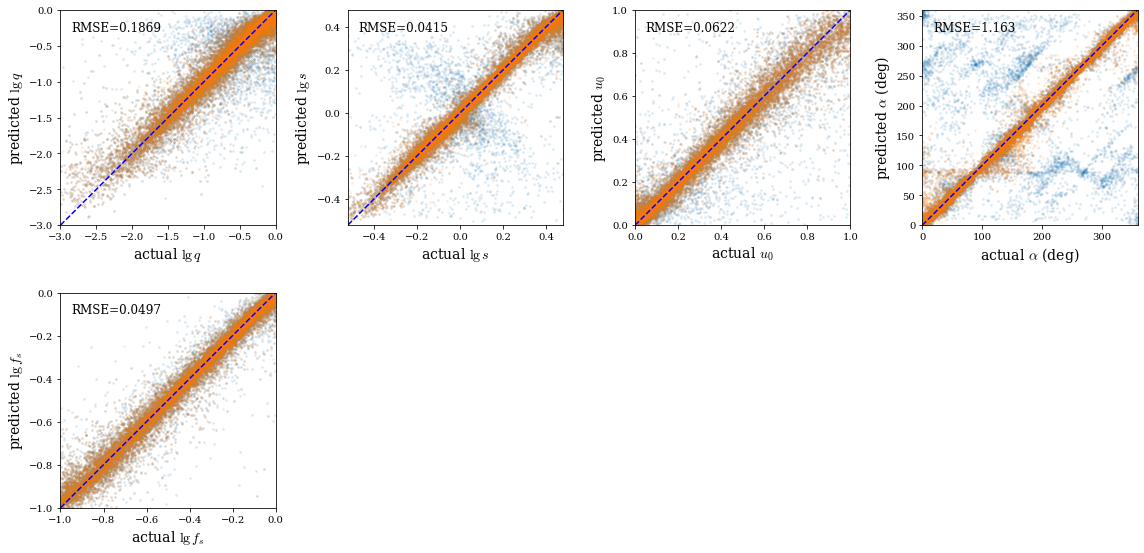

In [10]:
X_gap = torch.tensor(np.load('/work/hmzhao/X_gap.npy'))

# CDE interpolation with log_sig
depth = 3; window_length = max(X_gap.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_gap, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

pis_gap, locs_gap, scales_gap = inference(model, size, 4096, coeffs, device, full_cov=False)

pred_gap = get_peak_pred(pis_gap, locs_gap, scales_gap, Y)

rmse_gap = plot_params(size, Y, *pred_gap, title=None)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.05687363955809601
mse of log10q close:  0.026381707885790407
constraint 0.99371337890625
correct 0.9098335483078435
mse of log10s global:  0.011291401060379236
mse of log10s close:  0.0013241127924335887
constraint 0.9898681640625
correct 0.8869157725983475
mse of u0:  0.00928433338392265
mse of u0:  0.003278275913464434
constraint 0.9920654296875
correct 0.907099790820721
mse of alpha global:  5621.943032957591
mse of alpha close:  227.23415082762082
constraint 0.98681640625
correct 0.779750123701138
mse of log10fs global:  0.0028608480187683745
mse of log10fs close:  0.001887332680840009


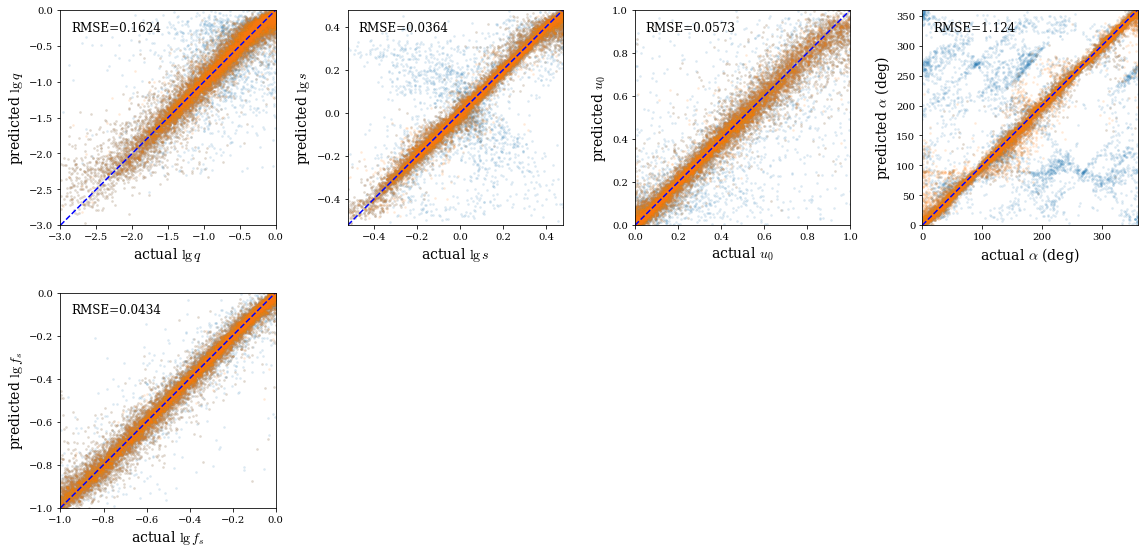

In [12]:
X_even = np.load('/work/hmzhao/KMT-fixrho-even.npy')
X_even = torch.tensor(X_even)

# CDE interpolation with log_sig
depth = 3; window_length = max(X_even.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_even, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

pis, locs, scales = inference(model, size, 4096, coeffs, device, full_cov=False)

pred_even = get_peak_pred(pis, locs, scales, Y)

rmse_even = plot_params(size, Y, *pred_even, title=None)

In [14]:
mse_close

array([[0.00377349, 0.03399402, 0.00169521, 0.00741093, 0.00220965],
       [0.00422219, 0.0394059 , 0.00194751, 0.00772978, 0.00267407],
       [0.0048766 , 0.05118116, 0.0024343 , 0.00814764, 0.00330616],
       [0.00762386, 0.10504442, 0.00464713, 0.00992826, 0.00553802]])

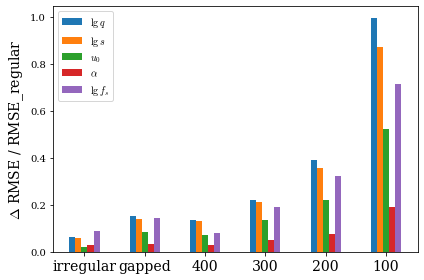

In [23]:
mse_close = np.load('./mse_sub.npy')
rmse_sub = np.sqrt(mse_close[:, [1, 2, 0, 3, 4]]).T

# fig = plt.figure(figsize=(4, 4))
width = 0.1
labels = [r'$\lg q$', r'$\lg s$', r'$u_0$', r'$\alpha$', r'$\lg f_s$']
cats = ['500\nregular', 'irregular', 'gapped', '400', '300', '200', '100']
markers = ['o', 's', '^', '+', 'x']
rmses = np.stack([rmse_even, rmse, rmse_gap], axis=-1)
rmses = np.hstack([rmses, rmse_sub])
rmses = rmses / rmses[:, [0]]
left = 1; right = None
for i, label in enumerate(labels):
    plt.bar(np.arange(len(cats[left:right]))+(i-2)*width, rmses[i, left:right]-1, width, label=label)
    # plt.plot(cats[left:right], rmses[i, left:right]-1, linestyle='dashed')
plt.ylabel(r'$\Delta$ RMSE / RMSE_regular', fontsize=14)
plt.ylim(bottom=0)
plt.xticks(np.arange(len(cats[left:right])), cats[left:right], fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('./rmse.pdf')
plt.show()